In [1]:
from ada_haar import *
from haar_bin import phantom
from numpy import savez, load, random, concatenate, linspace
from os import makedirs; makedirs('images', exist_ok=True); makedirs('videos', exist_ok=True)
from os.path import join
from tqdm.notebook import tqdm

VID = True

%matplotlib notebook
from matplotlib.pyplot import legend, figure as mpl_figure, close, savefig, rcParams, subplot, plot, gca, tight_layout

rcParams['figure.figsize'] = [9.5, 6]
def figure(name, *args, **kwargs):
    close(name); f = mpl_figure(name, *args, **kwargs);return f

def type2str(T):
    if T is True:
        return 'adaptive'
    elif T is False:
        return 'fixed'
    else:
        return T

def opt2vid(iters, phant, alg=None):
    if VID:
        if alg is None:
            alg = ''
        else:
            alg = alg.replace(' ','_').replace(',','_').replace('(','').replace(')','').replace('__','_')
        return {'filename':join('videos','haar_vid_'+phant+'_' + alg),
               'fps':int(log(iters[0]) / log(iters[1]) / 30) + 1}
    else:
        return None

COLORS = rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
%matplotlib notebook

In [3]:
try:
    with load(join('data','haar_arrays.npz'), allow_pickle=True) as tmp:
        results = tmp['results'].item(0).copy()
    tmp = Haar_2D(1, Haar_space(dim=2, init=10))
    for k,v in results.items():
        results[k] = (tmp.from_discrete(v[0]),) + v[1:]
except Exception:
    results = {}
            
def set_result(recon, record, iters, phantom, name=None):
    arr = record.extras.T.copy()
    record.I[0] = 1
    key = (('Circle' if phantom[0]=='C' else 'Shepp-Logan',)
           +tuple(iters)+(str(name),))
    results[key] = recon, record.I, record.T, arr
    return recon, record.I, record.T, arr

def Result(iters=None, phantom='S', name=None):
    s = 'Circle' if phantom[0]=='C' else 'Shepp-Logan'
    check = [(0,s)]
    if iters is not None:
        if isscalar(iters):
            check.append((1,iters))
        else:
            check.append((1,iters[0]))
            check.append((2,iters[1]))
    if name is not None:
        check.append((3,str(name)))
        
    sublist = [r for r in results 
               if all(r[k]==v for k,v in check)]
    if len(sublist) == 0:
        return None
    elif len(sublist) == 1:
        return results[sublist[0]]
    else:
        return [results[r] for r in sublist]

labels = ['E', 'discrete error', 'continuous error', 
          'number of pixels', 'depth', 'efficiency']

def best_fit(x,y,rate,shift=25):
    x = x**(-float(rate))
    scale = max(1e-8/x.min(), (y/x).max()/shift)
    return scale * x

def set_axes(ax, I):
#     ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(left=1, right=I)
    ax.set_ylim(bottom=1e-11, top=1)
    ax.grid(True, 'major', 'both')
    
def mid(x): return x[len(x)//6:-len(x)//6]

long_iters = (int(1e3),1.05)

# Initialise examples

In [4]:
random.seed(1)
dim, level = 2, 10

# The ground-truth
x,y = linspace(0, 1, 2 ** level).reshape(-1,1), linspace(0, 1, 2 ** level).reshape(1,-1)
gt = {
    'Circle':Haar_2D(1, Haar_space(dim=2, init=level)).from_discrete(
        ((x - .5) ** 2 + (y - .5) ** 2 < .3 ** 2).astype(float)),
    'Shepp-Logan':Haar_2D(1, Haar_space(dim=2, init=level)).from_discrete(
        phantom(2**level))
}

A = Haar2Sino(linspace(0, 180, 52)[1:-1], linspace(-.5, .5, 51), Haar_space(2, dim=2), centre=[.5] * 2)
data = {k:A(v) for k,v in gt.items()}

# Noisy data, Laplace distributed
noise = {'Circle':.05, 'Shepp-Logan':0}
data = {k:v + Norm(v)/ (2 * v.size) ** .5 * random.laplace(0,noise[k],v.shape) for k,v in data.items()}

weight = {'Circle':(.1,2e-3), 'Shepp-Logan':(.1,1e-3)}

# Run examples

In [5]:
long_runs = [('Greedy','Greedy FISTA'), 
             (('FB',{'scale':2}), 'FB'),
             (('FISTA',{'a':2}), 'FISTA, d=2'),
             (('FISTA',{'a':20}), 'FISTA, d=20'),
             (('FISTA',{'a':2, 'restarting':True}), 'Restarting FISTA, d=2'),
        ]
names = 'Greedy FISTA', 'FISTA, d=20'

In [6]:
for phant in tqdm(('Circle', 'Shepp-Logan'),desc='Phantom',smoothing=0):
    for alg,name in tqdm(long_runs,desc='Long runs %s'%phant,smoothing=0):
        if Result(long_iters,phant,name) is not None:
            continue
        recon, record = Haar_tomo(A, data[phant], *weight[phant], long_iters,plot=VID,
                                  vid=opt2vid(long_iters,phant,name), prnt=False, algorithm=alg)
        set_result(recon, record, long_iters, phant, name)


savez(join('data','haar_arrays.npz'), results={k:(v[0].discretise(10),)+v[1:] for k,v in results.items()})

In [7]:
%matplotlib notebook
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Data

<IPython.core.display.Javascript object>


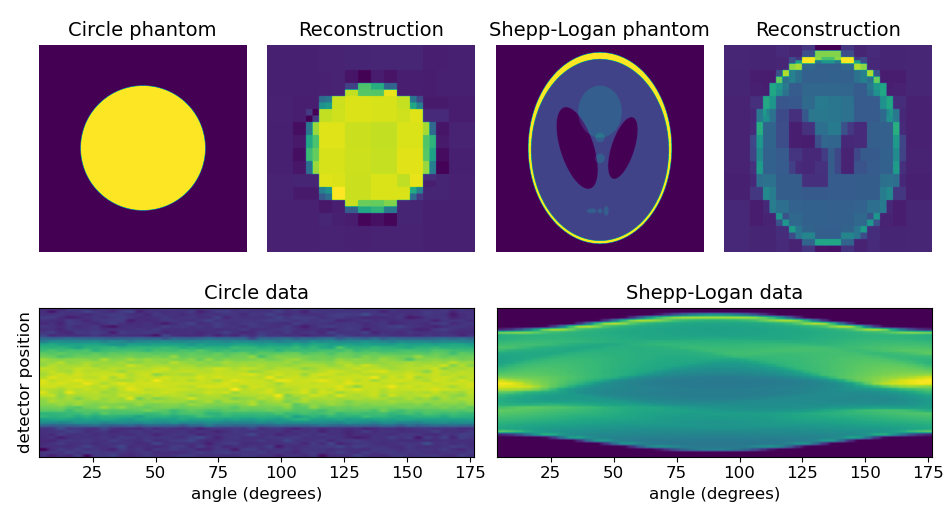

C:\Users\Rob\.conda\envs\ada_recon\lib\site-packages\ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [13]:
from matplotlib import gridspec
fig = figure('Data', figsize=(9.5,6.5*.8));
G = gridspec.GridSpec(2,4, fig, height_ratios=[5, 3], hspace=.1, wspace=.1)
for I,phant in enumerate(('Circle','Shepp-Logan')):
    ax = fig.add_subplot(G.new_subplotspec((0,2*I), rowspan=1, colspan=1)); ax.axis('off')
    gt[phant].plot(level=10,ax=ax,extent=[-.5,.5,-.5,.5])
    ax.set_title('%s phantom'%phant)

    ax = fig.add_subplot(G.new_subplotspec((0,2*I+1), rowspan=1, colspan=1)); ax.axis('off')
    recon, i, t, record = Result(long_iters, phant, names[0])
    recon.plot(level=10,ax=ax,extent=[-.5,.5,-.5,.5])
    ax.set_title('Reconstruction')

    
G = gridspec.GridSpec(2,2, fig, height_ratios=[5, 3], hspace=None, wspace=None)
for I,phant in enumerate(('Circle','Shepp-Logan')):
    ax = fig.add_subplot(G.new_subplotspec((1,I), rowspan=1, colspan=1))
    A.plot(data[phant], ax=ax)
    ax.set_title('%s data'%phant)
    ax.set_xlabel('angle (degrees)')
    if I==0:
        ax.set_ylabel('detector position')
    ax.yaxis.set_ticks([])
fig.tight_layout()
savefig(join('images','haar_data.pdf'), dpi=300)

## Long comparisons

<IPython.core.display.Javascript object>


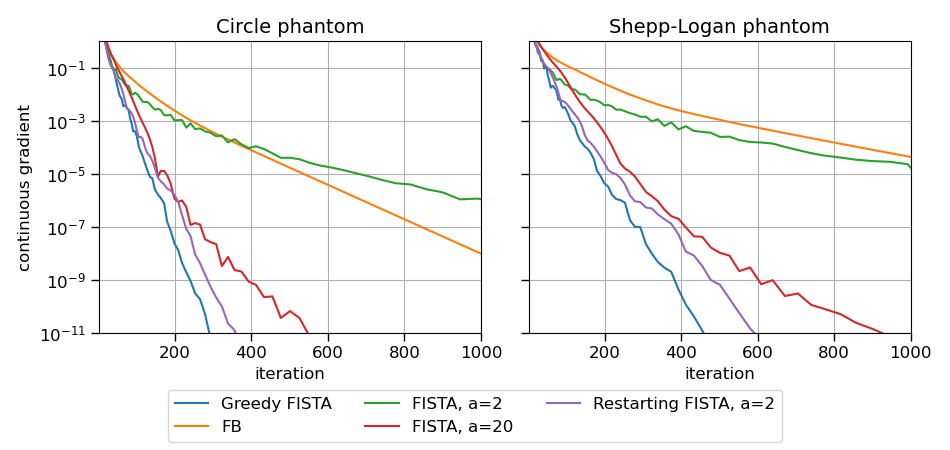

207076 pixels for Circle Greedy FISTA
135820 pixels for Circle FB
176656 pixels for Circle FISTA, d=2
275020 pixels for Circle FISTA, d=20
170860 pixels for Circle Restarting FISTA, d=2
123772 pixels for Shepp-Logan Greedy FISTA
142468 pixels for Shepp-Logan FB
113968 pixels for Shepp-Logan FISTA, d=2
183520 pixels for Shepp-Logan FISTA, d=20
113932 pixels for Shepp-Logan Restarting FISTA, d=2


In [9]:
colors = COLORS.copy()
colors = {k:colors.pop(0) for _,k in long_runs}

# Rows of recon are: 'F', 'discrete_err', 'cont_err', 'dof', 'depth', 'efficiency'
# record[0] = Function values
# record[1] = discrete gradient norm
# record[2] = continuous gradient norm
# record[3] = number of parametrised wavelets
# record[4] = maximum level of parametrised wavelet (resolution ~ 2^-record[4])
# record[5] = efficiency: record[3]/4^record[4]

fig = figure('Comparison', figsize=(9.5,4.5));
ax = fig.subplots(ncols=2,sharex='all',sharey='all')
for I,phant in enumerate(('Circle', 'Shepp-Logan')):
    for alg,name in long_runs:
        recon, i, t, record = Result(long_iters, phant, name)
        ax[I].plot(i, record[2], 
             color=colors[name],
             label=name.replace('d=','a=') if I==0 else None) # Discrete gap
        print(int(record[3].max()), 'pixels for', phant, name)
    set_axes(ax[I], long_iters[0]); ax[I].set_title('%s phantom'%phant)
    ax[I].tick_params(length=6, width=1, which='major')
    ax[I].tick_params(length=3, which='minor')
    ax[I].set_xlabel('iteration'); 
ax[0].set_ylabel('continuous gradient')
fig.legend(loc='lower center', ncol=3)
tight_layout()
fig.subplots_adjust(bottom=0.26)
savefig(join('images','haar_convergence.pdf'))

<IPython.core.display.Javascript object>


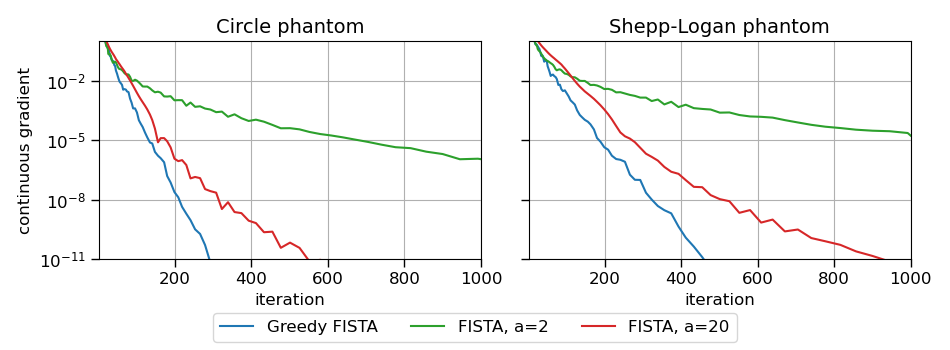

In [10]:
colors = COLORS.copy()
colors = {k:colors.pop(0) for _,k in long_runs}

fig = figure('Comparison short', figsize=(9.5,3.5));
ax = fig.subplots(ncols=2,sharex='all',sharey='all')
for I,phant in enumerate(('Circle', 'Shepp-Logan')):
    for alg,name in long_runs:
        if 'FB' in name or 'Restarting' in name:
            continue
        recon, i, t, record = Result(long_iters, phant, name)
        ax[I].plot(i, record[2], 
             color=colors[name],
             label=name.replace('d=','a=') if I==0 else None) # Discrete gap
    set_axes(ax[I], long_iters[0]); ax[I].set_title('%s phantom'%phant)
    ax[I].tick_params(length=6, width=1, which='major')
    ax[I].tick_params(length=3, which='minor')
    ax[I].set_xlabel('iteration'); 
ax[0].set_ylabel('continuous gradient')
fig.legend(loc='lower center', ncol=3)
tight_layout()
fig.subplots_adjust(bottom=0.26)
savefig(join('images','haar_convergence_short.pdf'))

## Long with zoom

<IPython.core.display.Javascript object>


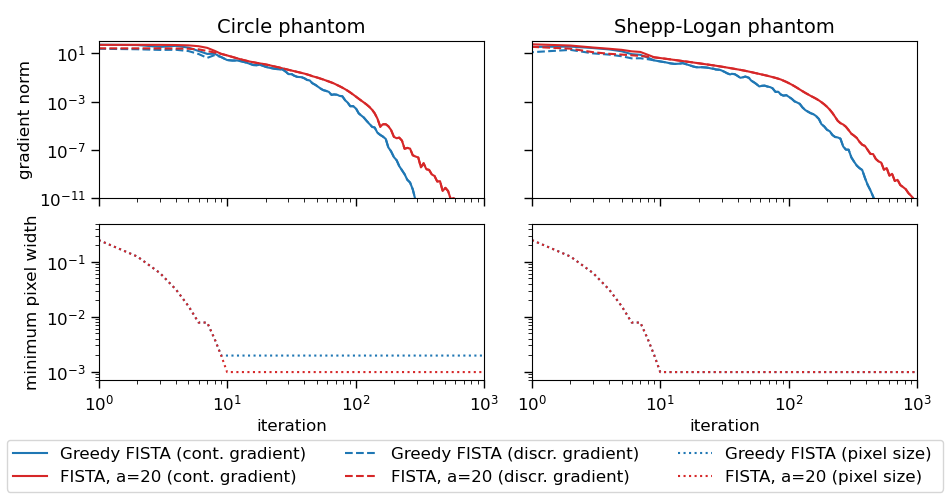

In [11]:
fig = figure('adaptive comparison', figsize=(9.5,5))
ax = fig.subplots(2,2,sharex='all',sharey='row', subplot_kw={'xscale':'log','yscale':'log'})
for I,phant in enumerate(('Circle', 'Shepp-Logan')):
    for alg,name in long_runs:
        if name not in names:
            continue
        recon, i, t, record = Result(long_iters, phant, name)
        ax[0][I].plot(i, record[2], color=colors[name],
             linestyle='solid', label=(name.replace('d=','a=') + ' (cont. gradient) ') if I==0 else None)
        ax[1][I].plot(i, 2.**-record[4], color=colors[name],
             linestyle='dotted', label=(name.replace('d=','a=') + ' (pixel size) ') if I==0 else None)
    for alg,name in long_runs:
        if name not in names:
            continue
        recon, i, t, record = Result(long_iters, phant, name)
        ax[0][I].plot(i, record[1], color=colors[name],
             linestyle='dashed', label=(name.replace('d=','a=') + ' (discr. gradient) ') if I==0 else None)

    for a in ax[I]:
        a.tick_params(length=6, width=1, which='major')
        a.tick_params(length=3, which='minor')
    a = ax[0][I]; a.set_xlim(1,long_iters[0]); a.set_ylim(1e-11,100)
    a.set_title('%s phantom'%phant);
    a = ax[1][I]; a.set_xlim(1,long_iters[0]); a.set_ylim(7e-4,.5); a.set_yscale('log')
    a.set_xlabel('iteration'); 
ax[0][0].set_ylabel('gradient norm'); ax[1,0].set_ylabel('minimum pixel width')

fig.legend(loc='lower center', ncol=3)
tight_layout()
fig.subplots_adjust(bottom=0.24) 
savefig(join('images','haar_reduced_convergence.pdf'))

## Comparison with time

<IPython.core.display.Javascript object>


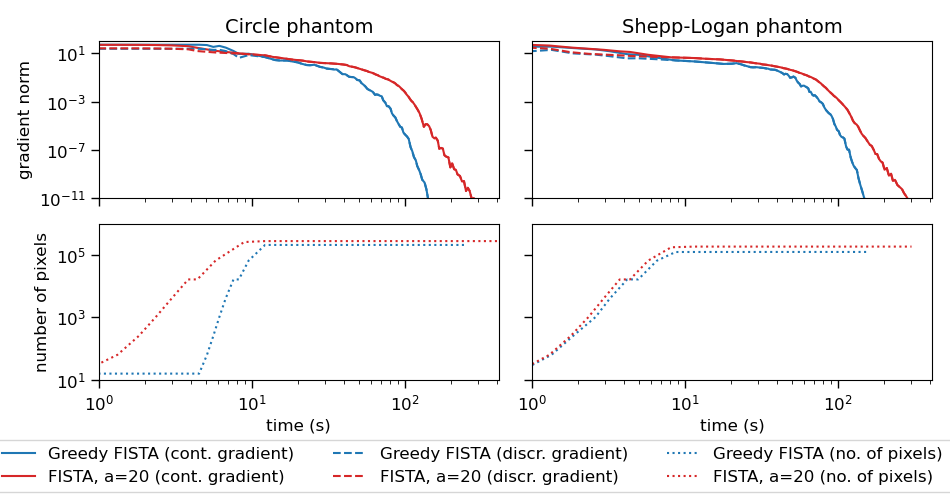

In [12]:
fig = figure('adaptive comparison time', figsize=(9.5,5))
ax = fig.subplots(2,2,sharex='all',sharey='row', subplot_kw={'xscale':'log','yscale':'log'})
T = 0
for I,phant in enumerate(('Circle', 'Shepp-Logan')):
    for alg,name in long_runs:
        if name not in names:
            continue
        recon, i, t, record = Result(long_iters, phant, name)
        ax[0][I].plot(t, record[2], color=colors[name],
             linestyle='solid', label=(name.replace('d=','a=') + ' (cont. gradient) ') if I==0 else None)
        ax[1][I].plot(t, record[3], color=colors[name],
             linestyle='dotted', label=(name.replace('d=','a=') + ' (no. of pixels) ') if I==0 else None)
    for alg,name in long_runs:
        if name not in names:
            continue
        recon, i, t, record = Result(long_iters, phant, name)
        ax[0][I].plot(t, record[1], color=colors[name],
             linestyle='dashed', label=(name.replace('d=','a=') + ' (discr. gradient) ') if I==0 else None)
        T = max(T,t.max())

    for a in ax[I]:
        a.tick_params(length=6, width=1, which='major')
        a.tick_params(length=3, which='minor')
    a = ax[0][I]; a.set_xlim(1,T); a.set_ylim(1e-11,100)
    a.set_title('%s phantom'%phant);
    a = ax[1][I]; a.set_xlim(1,T); a.set_ylim(10,1e6); a.set_yscale('log')
    a.set_xlabel('time (s)'); 
ax[0][0].set_ylabel('gradient norm'); ax[1][0].set_ylabel('number of pixels')

fig.legend(loc='lower center', ncol=3)
tight_layout()
fig.subplots_adjust(bottom=0.24) 
savefig(join('images','haar_time_convergence.pdf'))